In [160]:
import numpy as np
from tqdm import tqdm
import random


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import spacy
nlp = spacy.load('en_core_web_sm')


def lemmatizer(text):
    doc = nlp(text)
    return " ".join([t.lemma_ for t in doc])

# Carga de datos
Vamos a descargar un dataset de regresión sobre texto.

Datasets info: https://huggingface.co/datasets/app_reviews

In [4]:
from datasets import load_dataset

dataset = load_dataset("app_reviews")

Using custom data configuration default
Reusing dataset app_reviews (/home/rodri/.cache/huggingface/datasets/app_reviews/default/0.0.0/af305ac963fd8dff5976dd341e97edf3a2933c3509a58885caace361c5cd3fe3)


In [5]:
dataset["train"]

Dataset({
    features: ['package_name', 'review', 'date', 'star'],
    num_rows: 288065
})

In [6]:
sorted(zip(*np.unique(dataset["train"]["package_name"], return_counts=True)), key=lambda x: x[1], reverse=True)[:10]

[('com.google.android.gms', 103535),
 ('org.telegram.messenger', 22816),
 ('org.ppsspp.ppsspp', 9771),
 ('com.frostwire.android', 8867),
 ('com.google.android.marvin.talkback', 7807),
 ('org.wikipedia', 5410),
 ('net.sourceforge.opencamera', 3992),
 ('org.wordpress.android', 3200),
 ('com.google.android.apps.authenticator2', 2976),
 ('org.torproject.android', 2941)]

**Package name**: identificador de la aplicación

**Review**: texto con la opinión de la app

**Date**: Fecha de la review

**Star**: puntuación de 1 a 5 estrellas

In [7]:
package = 'org.telegram.messenger'
print("SELECTED PACKAGE: ", package)
texts_of_package = [i for i, x in enumerate(dataset["train"]["package_name"]) if x == package]

SELECTED PACKAGE:  org.telegram.messenger


In [8]:
texts = np.asarray(dataset['train']['review'])[texts_of_package]
targets = np.asarray(dataset['train']['star'])[texts_of_package]
print("Number of samples: ", len(texts))

Number of samples:  22816


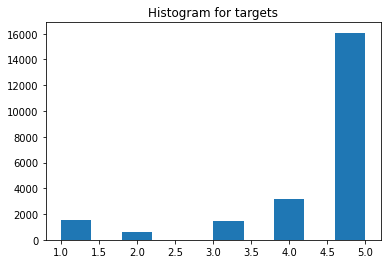

In [9]:
plt.hist(targets)
plt.title("Histogram for targets");

In [10]:
for i in range(5):
    print(texts[i])
    print(f"{targets[i]} stars")
    print("=======================")

Awesome app
5 stars
Nice
1 stars
Rkj Fine
5 stars
My Telegram I Love It
5 stars
Its good application i love it.....
5 stars


Vamos a simular no tener la gran cantidad de datos que tenemos. Para ello vamos a tomar solo una pequeña parte de las muestras.

In [96]:
n_samples_train = 2_000
n_samples_test = 1_000

Separamos en training y test.

In [97]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, targets, train_size=n_samples_train, test_size=n_samples_test)


In [98]:
# texts_train = list(map(lemmatizer, texts_train))
# texts_test = list(map(lemmatizer, texts_test))

# Generación de features
Vamos a usar un CountVectorizer. Se generarán N features, una por cada palabra que aparezca en el dataset. Cada texto será codificado un vector de N posiciones, donde cada posición representa el número de veces que contiene la palabra correspondiente.

In [99]:
from sklearn.feature_extraction.text import CountVectorizer

stopwords = ["best", "bad", "love", "hate", "great", "good", "thanks", "not", "awesome"]
stopwords = []
cv = CountVectorizer(
    ngram_range=(1, 3), # Se generan n-gramas de hasta 3 tokens
    min_df=2, # Solo se tomarán las palabras que aparezcan al menos un número mínimo de veces
    stop_words=stopwords
)
X_train = cv.fit_transform(texts_train)

In [100]:
print("Algunas de las features generadas: ", random.sample(cv.get_feature_names(), 10))

Algunas de las features generadas:  ['but there', 'and the best', 'the new', 'the problem is', 'status', 'add features', 'made in', 'good its', 'min', 'it but']


In [101]:
X_test = cv.transform(texts_test)

In [102]:
print("TAMAÑO DEL DATASET DE ENTRANAMIENTO: ", X_train.shape)

TAMAÑO DEL DATASET DE ENTRANAMIENTO:  (2000, 3338)


Vamos a escalar las features para que tengan la misma norma.

En lugar de escalarlo a norma 1, vamos a hacerlo de forma que todos tengan la norma de la feauture con mayor norma. Esto evita algunos problemas de redondeos a cero.

In [103]:
X_train_norm = X_train.toarray()
X_test_norm = X_test.toarray()
higher_norm = max([np.linalg.norm(X_train_norm[:, i]) for i in range(X_train.shape[1])])
       
for i in range(X_train.shape[1]):
    coeff = higher_norm / np.linalg.norm(X_train_norm[:, i])
    X_train_norm[:, i] = X_train_norm[:, i] * coeff
    X_test_norm[:, i] = X_test_norm[:, i] * coeff
    

# Modelo baseline: Linear Regressor
Entrenamos un regresor lineal simple.

In [155]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [105]:
lr = LinearRegression().fit(X_train, y_train)

In [156]:
print("Training score: ", mean_squared_error(y_train, lr.predict(X_train)))
print("Test score: ", mean_squared_error(y_test, lr.predict(X_test)))

Training score:  0.23343088340881468
Test score:  4.288439983188699


In [157]:
n_important_words = 20
print("MOST IMPORTANT {} words".format(n_important_words))
sorted(list(list(zip(cv.get_feature_names(), lr.coef_))), key=lambda x: abs(x[1]), reverse=True)[:n_important_words]

MOST IMPORTANT 20 words


[('thanks for this', 5.018114068121205),
 ('just awesome', 4.395789983814475),
 ('awesome thanks', -4.174124723052002),
 ('in india', -4.153721334990498),
 ('can not', -4.138257618172726),
 ('plz', -3.9999784425193976),
 ('nature', 3.9908777501692705),
 ('thanx', -3.742483269995731),
 ('app great', -3.7302621724770755),
 ('messaging', -3.622894801484117),
 ('emoji', -3.555705525979014),
 ('love this', 3.4557464412770895),
 ('like that', 3.452252300760432),
 ('share', 3.251390926841963),
 ('this application', -3.217071306059347),
 ('messaging app', 3.2009921796492184),
 ('that good', 3.1769481342644212),
 ('love this app', -3.142254006282895),
 ('not safe', -3.071337703831804),
 ('adds', 2.8384431178940353)]

# Lasso

In [158]:
from sklearn.linear_model import LassoCV
lasso_model = LassoCV(n_alphas=10).fit(X_train_norm, y_train)

/home/rodri/PycharmProjects/ClasificacionSinMuestras/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4354939221393579, tolerance: 0.18982993749999996
  positive)
/home/rodri/PycharmProjects/ClasificacionSinMuestras/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.357994019663181, tolerance: 0.18982993749999996
  positive)
/home/rodri/PycharmProjects/ClasificacionSinMuestras/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0508250557468273, tolerance: 0.18982993749999996
  positive)
/home/rodri/PycharmProjects/ClasificacionSinMuestras/venv/lib/pyt

In [159]:
print("Training score: ", r2_score(y_train, lasso_model.predict(X_train_norm)))
print("Test score: ", r2_score(y_test, lasso_model.predict(X_test_norm)))

Training score:  0.5298888228395948
Test score:  0.2166252799294175


In [144]:
len([c for c in lasso_model.coef_ if c != 0])

264

# OMP

In [135]:
from sklearn.linear_model import OrthogonalMatchingPursuit,  OrthogonalMatchingPursuitCV
from sklearn.pipeline import Pipeline


In [150]:
omp =  OrthogonalMatchingPursuitCV(max_iter=50)
omp = omp.fit(X_train_norm, y_train)

In [130]:
from sklearn.model_selection import GridSearchCV
gcv = GridSearchCV(omp, param_grid={"n_nonzero_coefs": range(50, 200, 20)}, scoring="r2").fit(X_train_norm, y_train)

In [151]:
gcv = omp

In [152]:
gcv.n_nonzero_coefs_

6

In [153]:
print("Training score: ", r2_score(y_train, gcv.predict(X_train_norm)))
print("Test score: ", r2_score(y_test, gcv.predict(X_test_norm)))

Training score:  0.16044807136304295
Test score:  0.1197781876010513


In [154]:
not_null_indices = [i for i,x in enumerate(gcv.coef_) if x != 0]

    
sorted(list(filter(lambda x: x[1] != 0, list(zip(cv.get_feature_names(), gcv.coef_)))), key=lambda x: abs(x[1]), reverse=True) 

[('not', -0.38891198364213503),
 ('hate', -0.28465963730773114),
 ('religion', -0.2332330876632032),
 ('doesn', -0.23125299686186407),
 ('dont', -0.22753808831982078),
 ('trying', -0.2106107843028904)]

In [147]:
[t for t in texts if "religion" in t]

["I hate this app This application include some stickers (modern budha) and it's insulting our religion. And it shouldn't be there. So please  telegrame developers remove that sticker pack.",
 'Disappointed such a shame that an app with millions of users made a dumb move like insulting a religion. buddhist people are using this app too. so... good luck with pissing users off.',
 "Urgently remove the modern buddha stickers pack!!Are u making fun of religion???? 😶 Remove the 'modern buddha' stickers in ur stickers pack. It's insulting to Buddhism!!! 👎👎👎 👎👎👎👎👎",
 'Racist මේ app එක install කරන්න එපා. බුදුහාමුදුරුවන්ට නින්දා වෙන විදිහෙ sticker වගයක් තියනව.. There is sticker set named modern Buddha. Dont install this app. Stop making fun from any religion. Plz dont install this app.',
 "Please remove Lord Buddha Sticker Please reove Lord Buddha stickers from your app. It's a insulting for a religion and don't do this for any religion.",
 "Shoutout to all the telegram haters I can't believe p